<a href="https://colab.research.google.com/github/subornaa/Data-Analytics-Tutorials/blob/main/Geospatial_Data_Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Data Analysis in Python

<img src = 'https://drive.google.com/uc?id=1WC7SSdfFseYRgmZ6lbodv898zi2nquJ0' width = 80%>

## Introduction and Dataset Background

### Geospatial Data

In this tutorial, we will explore the three main types of spatial data:

1) Raster

2) Vector

3) Point Cloud (i.e., 3D data)

The tutorial makes use of the Petawawa Research Forest (PRF) data, which is described in more detail in on the tutorial series [GitHub site](https://github.com/subornaa/Data-Analytics-Tutorials).

### Tutorial goals

This tutorial has several goals, motivated by the aformentioned data types.

**Goal 1: Summarize the coverage of different water bodies within the PRF and provide summary statistics.**

**Goal 2: Analyze the LiDAR-derived 99th height percentile raster and compare this height with plot level tree height measurements.**

**Goal 3: Calculate NDVI, NDMI, and NBR spectral indices using Sentinel-2 imagery and compare indices from 2018 and 2024 to assess forest change.**

**Goal 4: Perform height normalization on a subset of LiDAR point cloud data and analyze the forest structure from a 3-D perspective**

-----

**Notes:**

- Spectral indices are frormulas used to highlight specific patterns in spectral data using multiple bands. The indices relevant for this analysis include 1) Normalized Difference Vegetation Index (NDVI); 2) Normalized Difference Moisture Index (NDMI); 3) Normalized Burn Ratio (NBR). See this [guide for Sentinel-2 spectral indices](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/) for more information.

- Goal 4 relates to processing LiDAR point cloud data. This is a common task in forestry, and is typically executed using a variety of software including the [lidR package](https://r-lidar.github.io/lidRbook/) and [LAStools](https://lastools.github.io/). We will base methods in this tutorial for point cloud height normalization on those implemented in the lidR package.

### Dataset description

#### File Formats

Different spatial data types have different file formats. This is due to the way each data type is organized. Raster data is stored as a grid (array) format, and can be stored efficiently in formats such as GeoTIFF (.tif). In contrast, vector data is continuous and more complex, meaning it requires different file formats such as shapefile (.shp) or GeoPackage (.gpkg). Finally, LiDAR data is the most dense data format, with point clouds often containing millions of points, each with XYZ coordinates and additional attributes. Point cloud data derived from LiDAR sensors  is typically stored in .las or .laz formats.

#### Files

The following files are used in this tutorial:

- `plots.pgkg`
- `trees.csv`
- `boundary.gpkg`
- `water.gpkg`
- `p99.tif`
- `petawawa_s2_2018.tif`
- `petawawa_s2_2024.tif`
- `forest_point_cloud.las`
- `forest_point_cloud_footprint.gpkg`

Please refer to the README on the main GitHub page for a detailed description of each file.

### Packages

Due to the different file formats and data characteristics, each spatial data type has its own corresponding packages used for reading, writting, and processing in python.

While there are many packages available for each data type, we will use the following three in this tutorial:

**Raster: [rioxarray](https://corteva.github.io/rioxarray/stable/index.html)**

**Vector: [geopandas](https://geopandas.org/en/stable/)**

**Point Cloud: [laspy](https://laspy.readthedocs.io/en/latest/)**



# Install and load packages

**Run the cell below to install required packages**

In [ ]:
!pip install pandas==2.2.2
!pip install geopandas==1.0.1
!pip install matplotlib==3.10.1
!pip install rioxarray==0.19.0
!pip install laspy[lazrs]==2.5.4

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import matplotlib.pyplot as plt
import laspy
import numpy as np
from matplotlib.patches import Patch
from rasterio.plot import show, reshape_as_image
import rasterio
from shapely.geometry import box

# Download data

In [ ]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Downloading...
From (original): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
From (redirected): https://drive.google.com/uc?id=1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2&confirm=t&uuid=36ab21d0-f4bd-4e5e-97d4-c09ddef615fe
To: /content/prf_data.zip
100% 150M/150M [00:01<00:00, 84.4MB/s]
Archive:  prf_data.zip
  inflating: data/boundary.gpkg      
  inflating: data/trees.csv          
  inflating: data/plots.gpkg         
  inflating: data/water.gpkg         
  inflating: data/als_metrics.tif    
  inflating: data/forest_point_cloud.las  
  inflating: data/forest_point_cloud_footprint.gpkg  
  inflating: data/petawawa_s2_2018.tif  
  inflating: data/petawawa_s2_2024.tif  


['als_metrics.tif',
 'petawawa_s2_2024.tif',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'boundary.gpkg',
 'petawawa_s2_2018.tif',
 'water.gpkg',
 'plots.gpkg',
 'trees.csv']

# Visualization

**A great place to begin when working with any spatial data is visualization**

*Note:* in some cases the dataset may be too massive to visualize quickly/easily. In such cases, the data may need to be subset prior to visualizing.

**Question 1 - Use the `open_rasterio` function to load the 99th height percentile raster.**

In [ ]:
p99 = rio....(r'data/p99.tif')
p99

In [ ]:
# @title Solution
als_metrics = rio.open_rasterio(r'data/als_metrics.tif')
als_metrics

<xarray.DataArray (band: 67, y: 366, x: 746)> Size: 73MB
[18293412 values with dtype=float32]
Coordinates:
  * band         (band) int64 536B 1 2 3 4 5 6 7 8 9 ... 60 61 62 63 64 65 66 67
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60...

The 99th height percentile raster exists in the 37th position in als_metrics

In [ ]:
p99 = als_metrics[37]
p99

<xarray.DataArray (y: 366, x: 746)> Size: 1MB
[273036 values with dtype=float32]
Coordinates:
    band         int64 8B 38
  * x            (x) float64 6kB 2.974e+05 2.974e+05 ... 3.16e+05 3.16e+05
  * y            (y) float64 3kB 5.099e+06 5.099e+06 ... 5.09e+06 5.09e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('avg_95', 'avg', 'b10', 'b20', 'b30', 'b40', 'b50', 'b60...

Below is an example of how to visualize the LiDAR-derived 99th height percentile of the PRF

[]

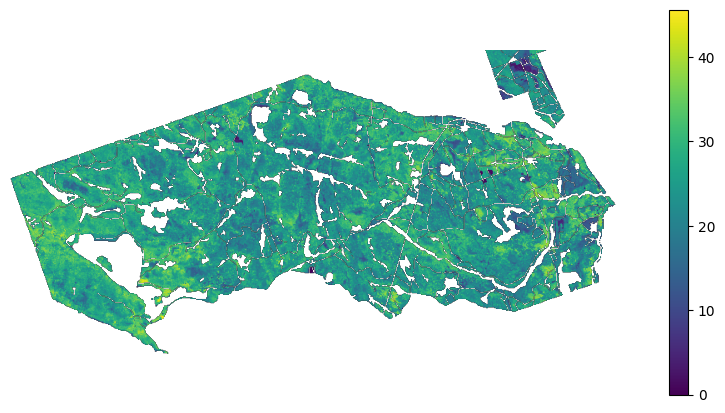

In [ ]:
# Raster data: Visualize the LiDAR-derived 99th height percentile of the PRF
fig, ax = plt.subplots(figsize=(10, 5))

cmap = 'viridis'

image_hidden = ax.imshow(p99, cmap=cmap)

show(p99, ax=ax, cmap=cmap)

fig.colorbar(image_hidden, ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

Below is a visulization of Imagery taken by Sentinel-2 (S2)

*Note 1:* S2 raster data has 12 bands. Bands 2 - 4 are blue-green-red (RGB; recall that python is 0-indexed though)
    # B2 = Blue
    # B3 = Green
    # B4 = Red

*Note 2:* When S2 bands are plotted, the image appears quite dark since some pixels (i.e., water) are very dark, making the rest of the image appear dark as well.

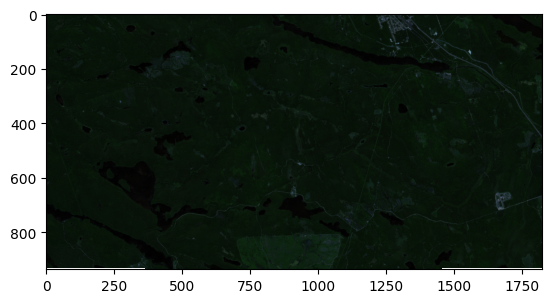

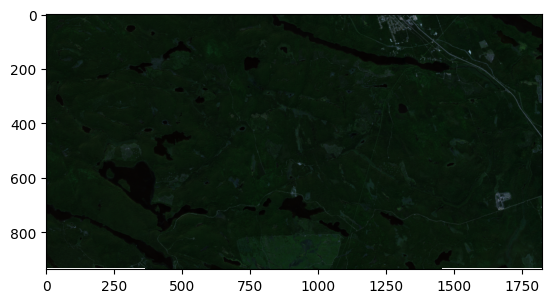

<Axes: >

In [ ]:
s2_2018 = rio.open_rasterio(r'data/petawawa_s2_2018.tif')
s2_2024 = rio.open_rasterio(r'data/petawawa_s2_2024.tif')

show(s2_2018.values[1:4], adjust=True)
show(s2_2024.values[1:4], adjust=True)

We can apply a contrast stretch to the image to make it more visually appealing.

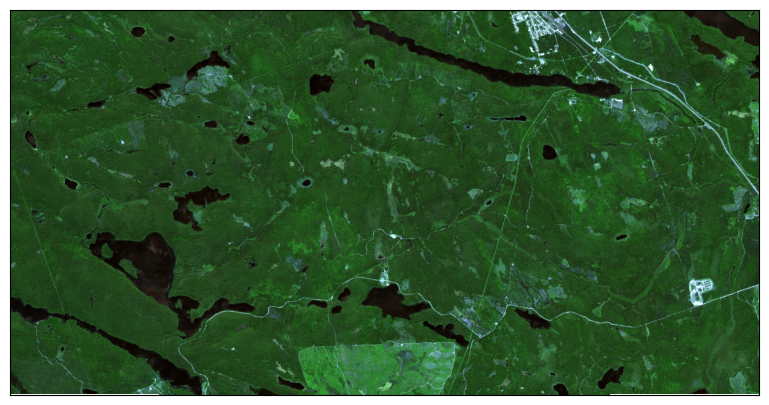

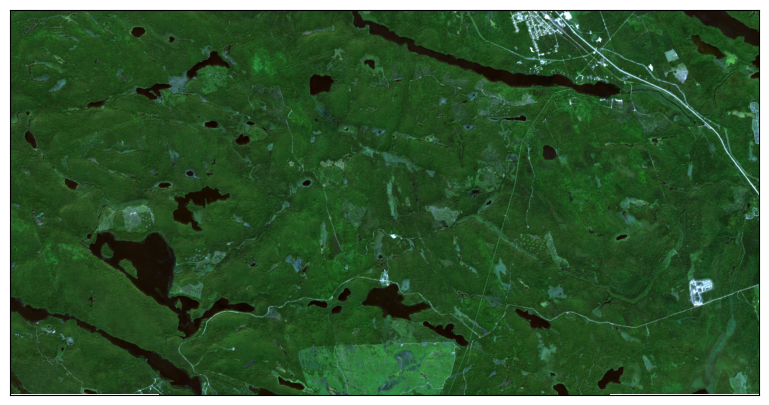

In [ ]:
def plot_rgb(ras, low_perc=1, high_perc=99):
    """
    Function to plot raster with band order blue, green, red.
    Contrast stretching can be applied using low_perc and high_perc.

    :param: ras: The image to plot.
    :param: low_perc: The lower percentile for contrast stretching.
    :param: high_perc: The upper percentile for contrast stretching.
    """

    img = reshape_as_image(ras)

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.set_xticks([])
    ax.set_yticks([])

    #find the values to do contrast stretching
    vmin, vmax = np.nanpercentile(img, (low_perc, high_perc))

    #Normalize the img based on the values in the previous line
    img = (img - vmin) / (vmax - vmin)

    #ensure values are between 0 and 1
    img = np.clip(img, 0, 1)

    plt.imshow(img, vmin=vmin, vmax=vmax)

plot_rgb(s2_2018.values[1:4], low_perc=0.1, high_perc=99.9)
plot_rgb(s2_2024.values[1:4], low_perc=0.1, high_perc=99.9)

**Question 2 - Below is an example of how vector data can be utilized. Your task is to visualize the plots and the PRF boundary. Please use the following color scheme:**

- Water: `blue`

- Plot points: `black`

- Boundary: `red`

Ensure that each element is clearly distinguished in the visualization.

In [ ]:
plots_gdf = gpd.read_file(r'data/plots.gpkg')
boundary_gdf = gpd.read_file(r'data/boundary.gpkg')
water_gdf = gpd.read_file(r'data/water.gpkg')

ax = water_gdf.plot(color = '...')
plots_gdf.plot(ax = ax, facecolor='orange', edgecolor='...', markersize=12)
boundary_gdf.plot(ax = ax, facecolor = 'none', edgecolor = '...')

legend_items = [Patch(facecolor='none', edgecolor='r', label='PRF Boundary'),
                Patch(facecolor='blue', edgecolor='grey', label='Water'),
                Patch(facecolor='orange', edgecolor='black', label='Plots')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

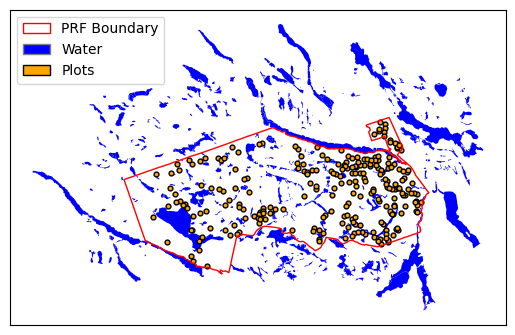

In [ ]:
# @title Solution
plots_gdf = gpd.read_file(r'data/plots.gpkg')
boundary_gdf = gpd.read_file(r'data/boundary.gpkg')
water_gdf = gpd.read_file(r'data/water.gpkg')

ax = water_gdf.plot(color = 'blue')
plots_gdf.plot(ax = ax, facecolor='orange', edgecolor='black', markersize=12)
boundary_gdf.plot(ax = ax, facecolor = 'none', edgecolor = 'red')

legend_items = [Patch(facecolor='none', edgecolor='r', label='PRF Boundary'),
                Patch(facecolor='blue', edgecolor='grey', label='Water'),
                Patch(facecolor='orange', edgecolor='black', label='Plots')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])


plt.show()


**Question 3 - Next, let's visualize a 3D point cloud using LiDAR data. First, read the data stored in the `las` variable, then extract the `x`, `y`, and `z` coordinates from this structure and store them in a point cloud (pc).**

In [ ]:
las = laspy.read(r'data/forest_point_cloud.las')

pc = np.vstack([las...., las...., las....]).transpose()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pc[:, 0],
            pc[:, 1],
            pc[:, 2],
            c=pc[:, 2],
            cmap='jet',
            linewidth=1,
            alpha=1,
            s=5)

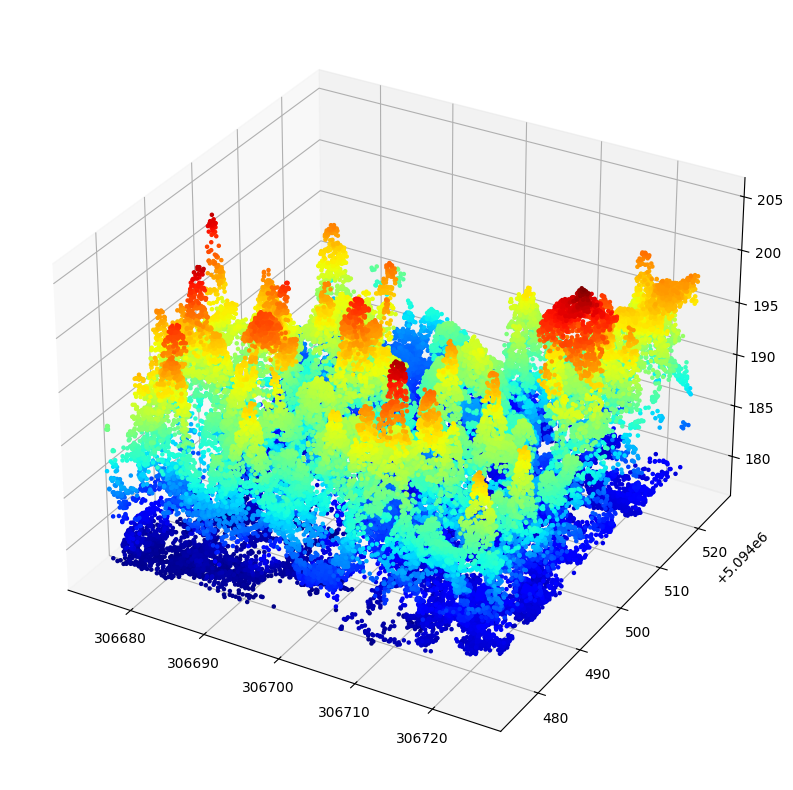

In [ ]:
# @title Solution
las = laspy.read(r'data/forest_point_cloud.las')

pc = np.vstack([las.x, las.y, las.z]).transpose()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(pc[:, 0],
            pc[:, 1],
            pc[:, 2],
            c=pc[:, 2],
            cmap='jet',
            linewidth=1,
            alpha=1,
            s=5)

Below is a repersentation of where the LiDAR data exists in the general area of our plots.

In [ ]:
lidar_footprint = gpd.read_file(r'data/forest_point_cloud_footprint.gpkg')

boundary_gdf = gpd.read_file(r'data/boundary.gpkg')

ax = boundary_gdf.plot(facecolor = 'none', edgecolor = 'black')
lidar_footprint.plot(ax = ax, edgecolor='red', markersize=12, linewidth=2)


legend_items = [Patch(facecolor='none', edgecolor='black', label='PRF Boundary'),
                Patch(facecolor='red', edgecolor='black', label='LiDAR Footprint')]

ax.legend(handles=legend_items, loc='upper left')
ax.set_xticks([])
ax.set_yticks([])


plt.show()

Now that we have explored our data a bit, time to do some analysis on it!

# Analysis

## Goal 1: Summarize Water Bodies

Our water dataset contains detailed information about all the water bodies in this area.

**Question 1: Reload the dataset and examine the first 5 rows of the dataset.**

In [ ]:
water = gpd....(r"data/water.gpkg")
water....()

In [ ]:
# @title Solution
water = gpd.read_file(r"data/water.gpkg")
water.head()

id                     type         name  \
0   1  Wetland Area, Permanent         None   
1   2    Water Area, Permanent  Spoor Creek   
2   3    Water Area, Permanent         None   
3   4  Wetland Area, Permanent         None   
4   5  Wetland Area, Permanent         None   

                                            geometry  
0  MULTIPOLYGON (((296583.22 5090477.67, 296582.6...  
1  MULTIPOLYGON (((298291.622 5089125.914, 298291...  
2  MULTIPOLYGON (((298580.643 5090542.072, 298582...  
3  MULTIPOLYGON (((297060.416 5090476.009, 297061...  
4  MULTIPOLYGON (((295738.629 5090164.043, 295740...

**Question 2 - Now, let's explore some basic statistics of the dataset. Please determine the following:**

- The total number of rows.

- The number of unique water types.

- The count of non-null rows.

- The count of null rows.

In [ ]:
print(f"Total number of features: {...(water)}")
print('-------------------------------------')
print(f"Unique 'type' categories:\n{water['type']....()}")
print('-------------------------------------')
print(f"Number of named features: {water['name']....()....()}")
print('-------------------------------------')
print(f"Number of unnamed features: {water['name']....().sum()}")

In [ ]:
# @title Solution
print(f"Total number of features: {len(water)}")
print('-------------------------------------')
print(f"Unique 'type' categories:\n{water['type'].unique()}")
print('-------------------------------------')
print(f"Number of named features: {water['name'].notnull().sum()}")
print('-------------------------------------')
print(f"Number of unnamed features: {water['name'].isnull().sum()}")

Total number of features: 555
-------------------------------------
Unique 'type' categories:
['Wetland Area, Permanent' 'Water Area, Permanent']
-------------------------------------
Number of named features: 73
-------------------------------------
Number of unnamed features: 482


**Question 3 - Let's dive deeper and extract more insightful information. Create a new column in the water dataset called `area_sq_m`. Note that `.area` is a GeoPandas property that calculates the area of each geometry in the geometry column, which will be helpful for this task.**

After adding the new column, calculate the following:

- The average area of the water bodies.

- The total area covered by water."

In [ ]:
water['area_sq_m'] = water.geometry....

#Note that :.2f simply rounds numbers to 2 decimal points.
print(f"\nMean area: {water['area_sq_m']....():.2f} sq meters")
print(f"Total area: {water['area_sq_m']....um():.2f} sq meters")

In [ ]:
# @title Solution
water['area_sq_m'] = water.geometry.area
print(f"\nMean area: {water['area_sq_m'].mean():.2f} sq meters")
print(f"Total area: {water['area_sq_m'].sum():.2f} sq meters")


Mean area: 51023.63 sq meters
Total area: 28318112.32 sq meters


Now lets visulize the how each water type is spread thjoughout the area. Perhpas a question you might find interesting for a later date is how much is the area of each type!

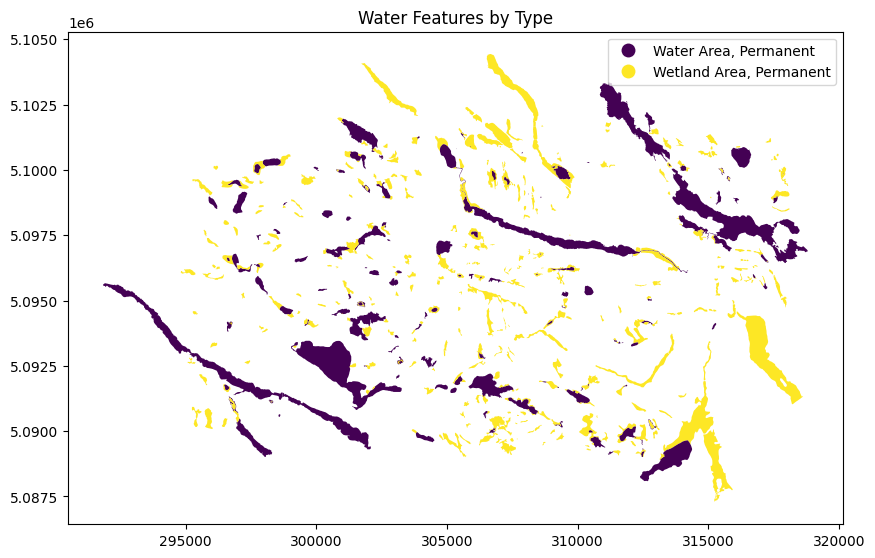

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
water.plot(column='type', cmap='viridis', legend=True, ax=ax)
ax.set_title('Water Features by Type')
plt.show()

In summary, this section focused on exploring available data to identify underlying patterns. Whether working with a standard dataset or geospatial data, similar exploration techniques can be applied effectively to both.

## Goal 2: Compare LiDAR with Plot Measurements

It's time to compare the LiDAR data with our plot data. The map below highlights their respective locations, with LiDAR data in blue and plot data in red.

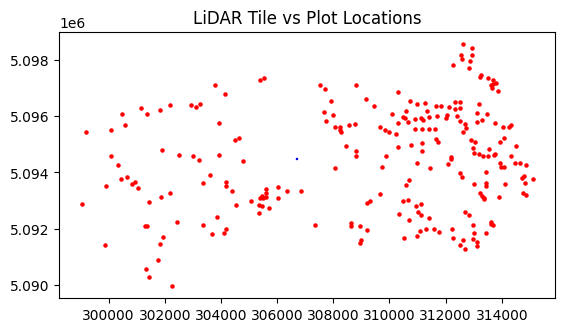

In [ ]:
bbox = box(pc[:, 0].min(), pc[:, 1].min(), pc[:, 0].max(), pc[:, 1].max())
lidar_bounds = gpd.GeoDataFrame(geometry=[bbox])

ax = lidar_bounds.plot(facecolor='none', edgecolor='blue', label='LiDAR bounds')
plots_gdf.plot(ax=ax, color='red', markersize=5, label='Plot points')
plt.title("LiDAR Tile vs Plot Locations")
plt.show()

The two datasets do not overlap, which limits the range of questions we can explore about their relationship. However, one meaningful question remains: How do the tree heights in the LiDAR-mapped area compare to the average tree heights in the other plots?

To investigate this, we will calculate the average tree height from our dataset, plot the LiDAR point cloud, and represent the average height as a grey rectangle on the plot. This visual comparison will help us see how the LiDAR points relate to the overall average height.

*Important Note:* Not all datasets use the same scale for their measurements. For example, the average tree height in the `trees` dataset is likely in meters.

However, if you run the code below, you'll see that the scale of the `las` data points is 0.1. This means the values are stored as integers and must be multiplied by 0.1 to convert them into real-world units, likely in meters.

In [ ]:
print("Scale:", las.header.scales)

Scale: [0.1 0.1 0.1]


**Question 1 - fill in the code below following these steps:**

- Step 1: load the tree dataset to achive the averge heights of all the trees
- Step 2: Convert the pc data points to thier real world value
- Step 3: Find the min and max values of the point cloud
- Step 4: Create a Z plane at `avg_height`

In [ ]:
#Step 1
trees_df = pd.read_csv("data/trees.csv")
avg_height = trees_df["height"]....()

#Step 2
pc_scaled = pc * ...

#Step 3
x_min, x_max = pc_scaled[:, 0]....(), pc_scaled[:, 0]....()
y_min, y_max = pc_scaled[:, 1]....(), pc_scaled[:, 1]....()

#Step 4
#Note: linspace generates a sequence of evenly spaced numbers over a specified interval.
#This code essentially creats the grid that will be seen in the visulization
x = np.linspace(x_min, x_max, 10)
y = np.linspace(y_min, y_max, 10)
X, Y = np.meshgrid(x, y)
Z = np.full_like(X, ...)

#Form the graph
fig = plt.figure(figsize=(30, 15))
ax = fig.add_subplot(projection='3d')
ax.scatter(pc_scaled[:, 0], pc_scaled[:, 1], pc_scaled[:, 2], c=pc_scaled[:, 2], cmap='jet', s=5, alpha=1)
ax.plot_surface(X, Y, Z, alpha=0.3, color='gray', edgecolor='none')
ax.set_title('LiDAR Point Cloud with Avg Tree Height Plane')
ax.set_xlabel('Easting (X)')
ax.set_ylabel('Northing (Y)')
ax.set_zlabel('Elevation (Z)')
plt.show()

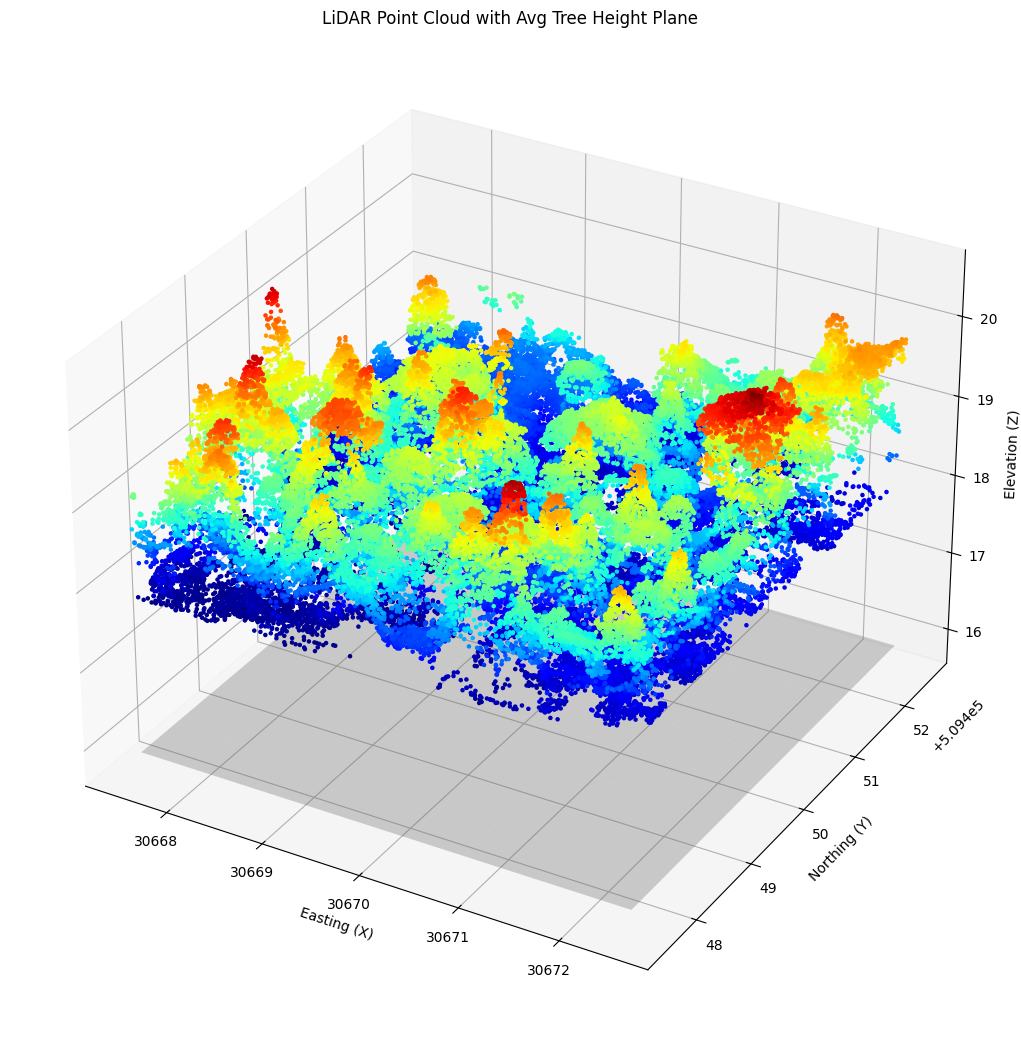

In [ ]:
# @title Solution
#Step 1
trees_df = pd.read_csv("data/trees.csv")
avg_height = trees_df["height"].mean()

#Step 2
pc_scaled = pc * 0.1

#Step 3
x_min, x_max = pc_scaled[:, 0].min(), pc_scaled[:, 0].max()
y_min, y_max = pc_scaled[:, 1].min(), pc_scaled[:, 1].max()

#Step 4
#Note: linspace generates a sequence of evenly spaced numbers over a specified interval.
#This code essentially creats the grid that will be seen in the visulization
x = np.linspace(x_min, x_max, 10)
y = np.linspace(y_min, y_max, 10)
X, Y = np.meshgrid(x, y)
Z = np.full_like(X, avg_height)

#Form the graph
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(projection='3d')
ax.scatter(pc_scaled[:, 0], pc_scaled[:, 1], pc_scaled[:, 2], c=pc_scaled[:, 2], cmap='jet', s=5, alpha=1)
ax.plot_surface(X, Y, Z, alpha=0.3, color='gray', edgecolor='none')
ax.set_title('LiDAR Point Cloud with Avg Tree Height Plane')
ax.set_xlabel('Easting (X)')
ax.set_ylabel('Northing (Y)')
ax.set_zlabel('Elevation (Z)')
plt.show()

**Question 2 - Now that we have this visulization, what information could we extract from it? What are some things you can say about this visulization?**

<img src = 'https://drive.google.com/uc?id=1P7Np3koo8tvnN7Nh1okUeU2_satXECMx' width = 60%>

[See full-size image](https://drive.google.com/uc?id=1P7Np3koo8tvnN7Nh1okUeU2_satXECMx)

*Answer here*

<details open>
<summary>Solution</summary>

Based on the visualization, the tree heights in the LiDAR-mapped area generally align with the regional average, appearing slightly taller than the average represented by the grey rectangle.

- If the grey rectangle were higher than all the data points, it would suggest that trees in this area are shorter than average.

- Conversely, if the grey rectangle were much lower than all the data points, it would indicate that the trees here are taller than average.
</details>

In summary, statistical techniques can be applied to geospatial data in meaningful and creative ways, as long as their use is well-justified.
For instance, analyzing tree height can reveal important insights about the health of a given plot of land. Fewer points or shorter trees may indicate sparse vegetation or environmental stress, while taller trees and higher point density might suggest a thriving ecosystem.

The key takeaway is that regardless of how an experiment is designed, it's essential to clearly explain the reasoning behind your design choices, doing so strengthens the credibility and clarity of your analysis.

## Goal 3: Compare Spectral Indices between 2018 and 2024

Now lets see how to analyze and visualize changes in vegetation and land cover over time using remote sensing data. Specifically, let us leverages satellite imagery from two different years (2018 and 2024) to compute and compare several vegetation indices and change maps. The indices help in monitoring various land characteristics such as vegetation health, moisture content, and fire impact.

The process includes the following key concepts:

Vegetation Indices (VIs): These are mathematical formulas that use reflectance values from different spectral bands (e.g., red, near-infrared, and short-wave infrared bands) to quantify vegetation health or water content. In this code, three common vegetation indices are calculated:

- NDVI (Normalized Difference Vegetation Index): Indicates vegetation health by comparing the difference between near-infrared (NIR) and red bands.

- NDMI (Normalized Difference Moisture Index): Reflects moisture content by comparing the NIR and short-wave infrared (SWIR1) bands.

- NBR (Normalized Burn Ratio): Used to assess the impact of wildfires or land degradation by comparing the NIR and SWIR2 bands.

**Question 1 - Helper Function to Calculate the Normalized Index.**

We first need to create a helper function that calculates the normalized index. This function takes two input bands:

- NIR band (Near-Infrared)

- Other band (e.g., red, SWIR1, SWIR2)

The function follows these steps:

- Subtract the values of the second band (e.g., red, SWIR1, or SWIR2) from the NIR band.

- Divide the result of the subtraction by the sum of both bands to normalize the value.

This normalized value will lie between -1 and 1, making it useful for comparing vegetation and land cover characteristics across different areas and times.

In [ ]:
def calculate_index(nir, other_band):
    return (... - ...) / (... + ...)

In [ ]:
# @title Solution
def calculate_index(nir, other_band):
    return (nir - other_band) / (nir + other_band)

To keep our code tidy, lets also create a function which can be used to extract all the bands from the dataset.

In [ ]:
def extract_bands(path):
    with rasterio.open(path) as src:
        red = src.read(4).astype('float32')
        nir = src.read(8).astype('float32')
        swir1 = src.read(11).astype('float32')
        swir2 = src.read(12).astype('float32')
        profile = src.profile
    return red, nir, swir1, swir2, profile

Load 2018 and 2024 bands

In [ ]:
red_2018, nir_2018, swir1_2018, swir2_2018, profile = extract_bands('data/petawawa_s2_2018.tif')

red_2024, nir_2024, swir1_2024, swir2_2024, _ = extract_bands('data/petawawa_s2_2024.tif')

**Question 2 - Now comes the fun part to calculate all the different indices.**

The formulas to calaute each indices are as follows;

- NDVI = NIR - RED
- NDMI = NIR - SWIR1
- NBR = NIR - SWIR2

In [ ]:
# Calculate indices
ndvi_2018 = calculate_index(..., ...)
ndvi_2024 = calculate_index(..., ...)
ndmi_2018 = calculate_index(..., ...)
ndmi_2024 = calculate_index(..., ...)
nbr_2018 = calculate_index(..., ...)
nbr_2024 = calculate_index(..., ...)

In [ ]:
# @title Solution
ndvi_2018 = calculate_index(nir_2018, red_2018)
ndvi_2024 = calculate_index(nir_2024, red_2024)
ndmi_2018 = calculate_index(nir_2018, swir1_2018)
ndmi_2024 = calculate_index(nir_2024, swir1_2024)
nbr_2018 = calculate_index(nir_2018, swir2_2018)
nbr_2024 = calculate_index(nir_2024, swir2_2024)

**Question 3 - Now that we have all the indices, we need to find the change between the two years. Fill in the code below.**

In [ ]:
ndvi_change = ndvi_2024 - ...
ndmi_change = ... - ...
nbr_change  = ... - ...

In [ ]:
# @title Solution
ndvi_change = ndvi_2024 - ndvi_2018
ndmi_change = ndmi_2024 - ndmi_2018
nbr_change  = nbr_2024 - nbr_2018

Finally, lets display the change maps by running the code below.

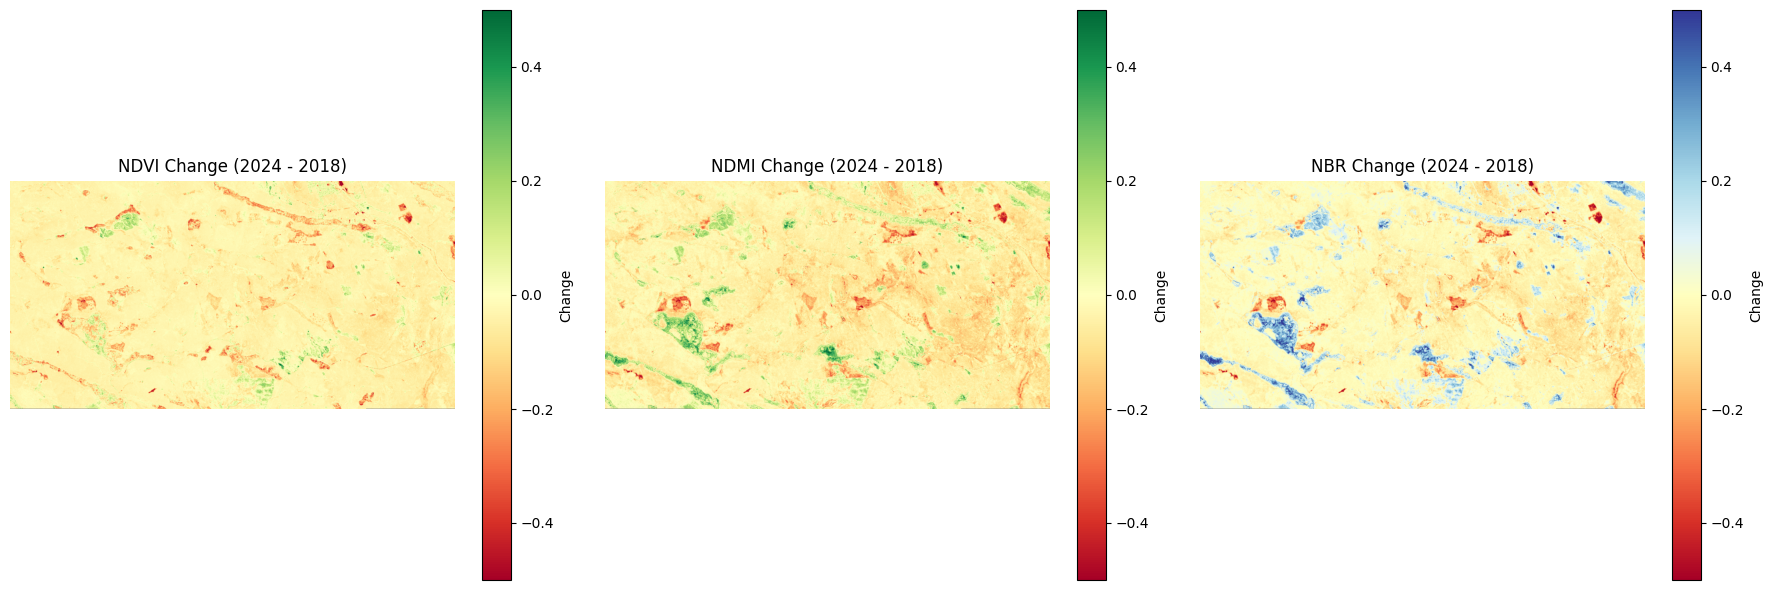

In [ ]:
def show_index_change(change, title, cmap='RdYlGn', ax=None):
    """
    Display the index change as a 2D image on the given axis.

    :param change: 2D array of the change in the index
    :param title: Title for the plot
    :param cmap: Colormap for the plot
    :param ax: Axis to plot on (used for subplots)
    """
    if ax is None:
        ax = plt.gca()  # If no axis is provided, use the current axis

    # Plot the change on the provided axis
    cax = ax.imshow(change, cmap=cmap, vmin=-0.5, vmax=0.5)
    ax.set_title(title)
    ax.axis('off')  # Turn off axis ticks and labels

    # Add color bar
    plt.colorbar(cax, ax=ax, label='Change')

# Create a figure with a horizontal layout (3 subplots)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Show the changes on the respective axes
show_index_change(ndvi_change, 'NDVI Change (2024 - 2018)', ax=axs[0])
show_index_change(ndmi_change, 'NDMI Change (2024 - 2018)', ax=axs[1])
show_index_change(nbr_change, 'NBR Change (2024 - 2018)', cmap='RdYlBu', ax=axs[2])

# Display the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

**Question 4 - What can you say about each of the maps and what each of the colours repersents.**
<img src = 'https://drive.google.com/uc?id=14Eh_wmPB7J6PFpK77NnOrtyluu9t57B8' width = 100%>

[See full-size image](https://drive.google.com/uc?id=14Eh_wmPB7J6PFpK77NnOrtyluu9t57B8)

*Answer here*

<details open>
<summary>Solution</summary>

1. NDVI Change (Normalized Difference Vegetation Index)

- Green areas: Increase in vegetation (positive change).

- Red areas: Decrease in vegetation (negative change).

- Yellow areas: Little to no change.


2. NDMI Change (Normalized Difference Moisture Index)

- Green areas: Increased moisture (perhaps healthier or more water-retentive vegetation).

- Red areas: Decreased moisture (indicating stress, dryness, or loss).

- Yellow areas: Minimal change.

3. NBR Change (Normalized Burn Ratio)


- Blue areas: Increase in NBR (likely recovery or regrowth post-disturbance).

- Red areas: Decrease in NBR (could indicate burn, degradation, or deforestation).

- Yellow areas: Stable conditions.

</details>

In summary, spectral indices graphs are extremely useful for identifying trends in a given area of land over time.
These simple visualizations can be interpreted by a general audience with minimal explanation, making them an effective way to communicate findings to a broader, non-technical audience.

## Goal 4: Analyze 3D LiDAR Point Cloud

Given points in 3D space, it is possible to estimate where the ground lies and potentially create a more accurate map of the underlying terrain.

[Here](!https://r-lidar.github.io/lidRbook/gnd.html) is some additional reading that provides a summary of the approach we'll be using.

*Note:* Some of the code may seem complex or intimidating at first, but don't worry! We'll walk through it step by step, so you can understand and apply it in your own work.

To begin, let's identify the components we need before writing any code.

First, we'll extract all the x, y, and z coordinates from the `las` structure, which we obtained in a previous step.

Next, we'll import the `griddata` function from the `scipy.interpolate` module, which is part of Python's scientific computing system. This function helps with interpolating scattered data, that is, estimating values at unknown points based on known data that isn't arranged in a regular grid. Simply put, if we have known data points at scattered (x, y) positions with associated z-values (like elevation), `griddata` allows us to estimate the z-values at new (x, y) positions.

Finally, we'll use a special data structure called a dictionary. Dictionaries allow us to efficiently group elevation (z) values into grid cells based on their (x, y) coordinates. This kind of grouping isn't as easily done with simpler structures like arrays.

In [ ]:
x, y, z = las.x, las.y, las.z
from scipy.interpolate import griddata
from collections import defaultdict

`estimate_ground_dtm` estimates a Digital Terrain Model (DTM) from a set of 3D points (x, y, z).
The idea is to approximate the ground surface by retaining only the lowest N% of points within each small grid cell as these are most likely to represent ground-level elevations.

*Aside:* We divide the area into grid cells to analyze local spatial patterns, improve processing efficiency, and simplify otherwise complex data. Think of it like examining a 10m x 10m plot of land rather than trying to make sense of an entire city's terrain all at once! It's much easier to spot trends and variations at a smaller, more manageable scale.

**Question 1 - fill in the code below using the green comments as a guide.**

In [ ]:
def estimate_ground_dtm(x, y, z, grid_res=1.0, percentile=5):
    """Estimate a DTM by filtering the lowest N% of points in each grid cell."""
    # Convert x and y to grid indices
    xi = ((x - x.min()) / grid_res).astype(int)
    yi = ((y - y.min()) / grid_res).astype(int)

    # Build dictionary to hold Z values per grid cell
    grid = defaultdict(list)
    for i, j, height in zip(xi, yi, z):

        #grid holds a list of all height values (z) in that cell
        grid[(..., ...)].append(height)

    # Compute low percentile Z per cell (e.g., 5th percentile = likely ground)
    ground_x = []
    ground_y = []
    ground_z = []

    #For each grid cell that has enough points:

        #Converts the grid index (i, j) back to real-world coordinates

        #Computes the low percentile height (e.g., 5th percentile)

        #Appends this as a "ground point"

    for (i, j), heights in grid.items():
        if len(heights) > 2:  # filter cells with enough points
            px = x.min() + ... * grid_res
            py = y.min() + ... * grid_res
            pz = np.percentile(..., ...)
            ground_x....(px)
            ground_y.append(...)
            ground_z.append(pz)

    #Output: filtered, lower-resolution set of x, y, z points that represent the estimated terrain surface (DTM)
    return np.array(ground_x), np.array(ground_y), np.array(ground_z)

In [ ]:
# @title Solution
def estimate_ground_dtm(x, y, z, grid_res=1.0, percentile=5):
    """Estimate a DTM by filtering the lowest N% of points in each grid cell."""
    # Convert x and y to grid indices
    xi = ((x - x.min()) / grid_res).astype(int)
    yi = ((y - y.min()) / grid_res).astype(int)

    # Build dictionary to hold Z values per grid cell
    grid = defaultdict(list)
    for i, j, height in zip(xi, yi, z):

        #grid holds a list of all height values (z) in that cell
        grid[(i, j)].append(height)

    # Compute low percentile Z per cell (e.g., 5th percentile = likely ground)
    ground_x = []
    ground_y = []
    ground_z = []

    #For each grid cell that has enough points:

        #Converts the grid index (i, j) back to real-world coordinates

        #Computes the low percentile height (e.g., 5th percentile)

        #Appends this as a "ground point"

    for (i, j), heights in grid.items():
        if len(heights) > 2:  # filter cells with enough points
            px = x.min() + i * grid_res
            py = y.min() + j * grid_res
            pz = np.percentile(heights, percentile)
            ground_x.append(px)
            ground_y.append(py)
            ground_z.append(pz)

    return np.array(ground_x), np.array(ground_y), np.array(ground_z)

`interpolate_dtm` takes a set of ground points (`ground_x`, `ground_y`, `ground_z`) and estimates ground elevation at arbitrary (x, y) locations using interpolation.

The goal is to determine the ground height at each original (x, y) position by referencing the known ground points.

*Aside:* Interpolation means estimating the value of data or a function between two known values. In this context, we're using known ground elevations to predict heights at locations where we don't have direct measurements.

**Question 2 - fill in the code below using the green comments as a guide.**

In [ ]:
def interpolate_dtm(ground_x, ground_y, ground_z, x, y):
    """Interpolate DTM at original point locations."""
    dtm = griddata(
        (..., ...),             # known ground positions
        ...,                    # known ground heights
        (..., ...),             # where you want to estimate
        method='linear',        # interpolate using triangles between nearby points
        fill_value=np.nan       # if outside convex hull, return NaN
    )

    #Fill NaNs using nearest interpolation. Essentially use a good guess to fill in missing pecies.
    nan_mask = np.isnan(dtm)
    if np.any(nan_mask):
        dtm[nan_mask] = griddata(
            (ground_x, ground_y),
            ground_z,
            (x[nan_mask], y[nan_mask]),
            method='nearest'
        )

    # an array of ground height values at each original (x, y) point
    return dtm

In [ ]:
# @title Solution

def interpolate_dtm(ground_x, ground_y, ground_z, x, y):
    """Interpolate DTM at original point locations."""
    dtm = griddata(
        (ground_x, ground_y),   # known ground positions
        ground_z,               # known ground heights
        (x, y),                 # where you want to estimate
        method='linear',        # interpolate using triangles between nearby points
        fill_value=np.nan       # if outside convex hull, return NaN
    )

    #Fill NaNs using nearest interpolation. Essentially use a good guess to fill in missing pecies.
    nan_mask = np.isnan(dtm)
    if np.any(nan_mask):
        dtm[nan_mask] = griddata(
            (ground_x, ground_y),
            ground_z,
            (x[nan_mask], y[nan_mask]),
            method='nearest'
        )

    # an array of ground height values at each original (x, y) point
    return dtm

`height_normalization_simple` performs height normalization on 3D point cloud data.

It estimates and subtracts the ground elevation (Digital Terrain Model, or DTM) from the raw height values, leaving only the above-ground height, such as the height of trees, buildings, or other structures.

**Question 3 - Using the previously completed functions, fill in the code below.**

In [ ]:
def height_normalization_simple(x, y, z, grid_res=1.0, percentile=5):
    gx, gy, gz = ...(x, y, z, grid_res=grid_res, percentile=percentile)
    dtm = ...(gx, gy, gz, x, y)

    # Normalization helps isolate how far above the ground each point is.
    z_normalized = z - ...
    return z_normalized, dtm

In [ ]:
# @title Solution
def height_normalization_simple(x, y, z, grid_res=1.0, percentile=5):
    gx, gy, gz = estimate_ground_dtm(x, y, z, grid_res=grid_res, percentile=percentile)
    dtm = interpolate_dtm(gx, gy, gz, x, y)
    z_normalized = z - dtm
    return z_normalized, dtm

Now it's time to create a plot and see the results of all our hard work!

The following code visualizes a 3D point cloud where each point's height has been normalized relative to ground level. In other words, it shows how high objects, such as trees or buildings, rise above the underlying terrain.

**Question 4 - Complete the code below.**

In [ ]:
# Pass your orginal x, y, z, values into the height_normalization_simple function to start the process!
z_normalized, dtm = ...(..., ..., ...)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of normalized heights
sc = ax.scatter(x, y, z_normalized, c=z_normalized, cmap='viridis', s=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height above ground (m)')
ax.set_title('3D Visualization of Height-normalized LiDAR')

fig.colorbar(sc, label='Height above ground (m)')
plt.show()

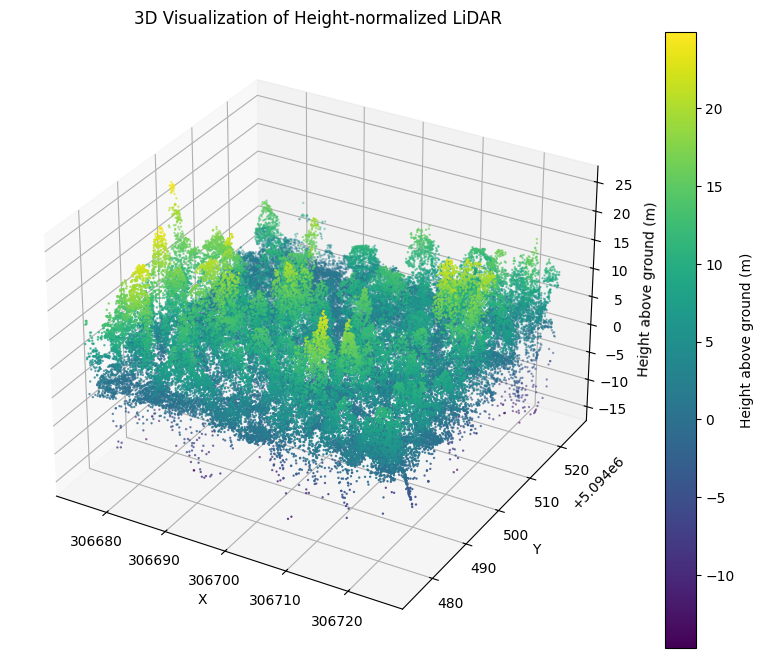

In [ ]:
# @title Solution
# Pass your orginal x, y, z, values into the height_normalization_simple function to start the process!
z_normalized, dtm = height_normalization_simple(x, y, z)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of normalized heights
sc = ax.scatter(x, y, z_normalized, c=z_normalized, cmap='viridis', s=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height above ground (m)')
ax.set_title('3D Visualization of Height-normalized LiDAR')

fig.colorbar(sc, label='Height above ground (m)')
plt.show()

In summary, by applying advanced techniques from SciPy, we've leveraged our existing dataset to predict additional, meaningful information.
While these estimates may not fully replace direct ground measurements, they offer a reliable and practical way to approximate terrain data, making them valuable for further analysis and applications.